In [ ]:
from google.colab import  drive
drive.mount( '/content/drive')

Mounted at /content/drive


In [ ]:
%tensorflow_version 1.x


TensorFlow 1.x selected.


In [ ]:
import tensorflow as tf 
tf.__version__


'1.15.2'

In [ ]:
!unzip '/content/drive/MyDrive/cropp.zip'

Archive:  /content/drive/MyDrive/cropp.zip
   creating: U_NET/
   creating: U_NET/train/
   creating: U_NET/train/003cee89357d9fe13516167fd67b609a164651b21934585648c740d2c3d86dc1/
   creating: U_NET/train/003cee89357d9fe13516167fd67b609a164651b21934585648c740d2c3d86dc1/images/
  inflating: U_NET/train/003cee89357d9fe13516167fd67b609a164651b21934585648c740d2c3d86dc1/images/003cee89357d9fe13516167fd67b609a164651b21934585648c740d2c3d86dc1.JPG  
   creating: U_NET/train/003cee89357d9fe13516167fd67b609a164651b21934585648c740d2c3d86dc1/masks/
  inflating: U_NET/train/003cee89357d9fe13516167fd67b609a164651b21934585648c740d2c3d86dc1/masks/003cee89357d9fe13516167fd67b609a164651b21934585648c740d2c3d86dc1.png  
   creating: U_NET/train/00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e/
   creating: U_NET/train/00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e/images/
  inflating: U_NET/train/00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e/images/00ae

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()


'/device:GPU:0'

In [ ]:
import os
import sys
import random
import warnings #
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import tensorflow as tf
import cv2

BATCH_SIZE = 8
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
TRAIN_PATH = '/content/U_NET/train/'
TEST_PATH = '/content/U_NET/validation/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed (seed)

Using TensorFlow backend.


In [ ]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]
#np.random.seed(10)

In [ ]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')

sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.JPG')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = resize(mask_, (IMG_HEIGHT, IMG_WIDTH,1), mode='constant', 
                                      preserve_range=True)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.JPG')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.2)
print('\nx_train',x_train.shape)
print('x_test',x_test.shape)
print('y_train',y_train.shape)
print('y_test',y_test.shape)

Getting and resizing train images and masks ... 


100%|██████████| 236/236 [00:43<00:00,  5.42it/s]

Getting and resizing test images ... 



100%|██████████| 44/44 [00:04<00:00, 10.91it/s]

Done!

x_train (188, 256, 256, 3)
x_test (48, 256, 256, 3)
y_train (188, 256, 256, 1)
y_test (48, 256, 256, 1)


In [ ]:
from keras.preprocessing import image

# Creating the training Image and Mask generator
image_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')
mask_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')

# Keep the same seed for image and mask generators so they fit together

image_datagen.fit(X_train[:int(X_train.shape[0]*0.9)], augment=True, seed=seed)
mask_datagen.fit(Y_train[:int(Y_train.shape[0]*0.9)], augment=True, seed=seed)

x=image_datagen.flow(X_train[:int(X_train.shape[0]*0.9)],batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y=mask_datagen.flow(Y_train[:int(Y_train.shape[0]*0.9)],batch_size=BATCH_SIZE,shuffle=True, seed=seed)



# Creating the validation Image and Mask generator
image_datagen_val = image.ImageDataGenerator()
mask_datagen_val = image.ImageDataGenerator()

image_datagen_val.fit(X_train[int(X_train.shape[0]*0.9):], augment=True, seed=seed)
mask_datagen_val.fit(Y_train[int(Y_train.shape[0]*0.9):], augment=True, seed=seed)

x_val=image_datagen_val.flow(X_train[int(X_train.shape[0]*0.9):],batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y_val=mask_datagen_val.flow(Y_train[int(Y_train.shape[0]*0.9):],batch_size=BATCH_SIZE,shuffle=True, seed=seed)

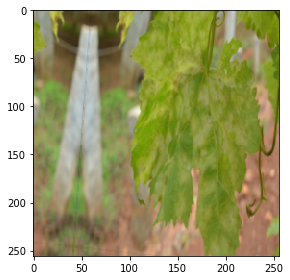

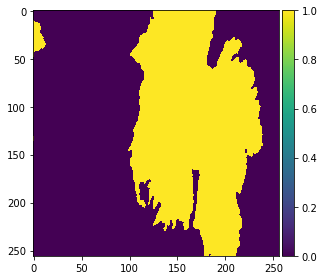

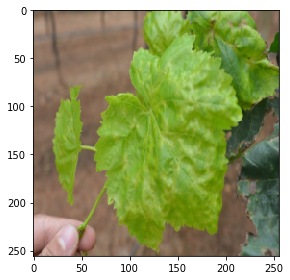

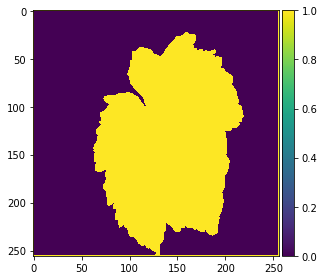

In [ ]:
#from matplotlib import pyplot as plt
%matplotlib inline

imshow(x.next()[0].astype(np.uint8))
plt.show()
imshow(np.squeeze(y.next()[0].astype(np.uint8)))
plt.show()
imshow(x_val.next()[0].astype(np.uint8))
plt.show()
imshow(np.squeeze(y_val.next()[0].astype(np.uint8)))
plt.show()

In [ ]:
train_generator = zip(x, y)
val_generator = zip(x_val, y_val)

In [ ]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [ ]:
def UNET(a,b,c,d):
    # Build U-Net model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255) (inputs)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    
    
    model = Model(inputs=[inputs], outputs=[outputs])
    opt = Adam(learning_rate= 1e-3, decay= 1e-3/100)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[mean_iou,'accuracy'])
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    model.summary()
    #earlystopper = EarlyStopping(patience=20, verbose=1)
    checkpointer = ModelCheckpoint('first_model.hd5', verbose=1, save_best_only=True)
    results = model.fit(a,b,batch_size=16,verbose=1,epochs=100,validation_data=(c,d),callbacks = [ checkpointer])
    global modelZ
    modelZ = model
    return modelZ
UNET(x_train, y_train,x_test,y_test)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 448         lambda_1[0][0]      

48/48 [==============================] - 0s 3ms/step


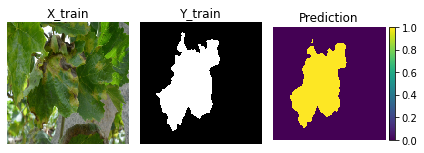

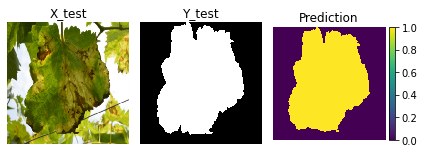

In [ ]:
def plotPredictions(a,b,c,d,e):
    model = e
    # Threshold predictions
    preds_train = model.predict(a[:int(a.shape[0]*0.9)], verbose=1)
    preds_val = model.predict(a[int(a.shape[0]*0.9):], verbose=1)
    preds_test = model.predict(c, verbose=1)
    preds_train_t = (preds_train > 0.5).astype(np.uint8)
    preds_val_t = (preds_val > 0.5).astype(np.uint8)
    preds_test_t = (preds_test > 0.5).astype(np.uint8)
    # Perform a sanity check on some random training samples
    ix = random.randint(0, len(preds_train_t))
    plt.subplot(1,3,1)
    plt.title("X_train")
    plt.axis('off')
    imshow(a[ix])
    plt.subplot(1,3,2)
    plt.title("Y_train")
    plt.axis('off')
    imshow(np.squeeze(b[ix]))
    plt.subplot(1,3,3)
    plt.title("Prediction")
    plt.axis('off')
    imshow(np.squeeze(preds_train_t[ix]))
    plt.show()
    # Perform a sanity check on some random validation samples
    ix = random.randint(0, len(preds_val_t))
    plt.subplot(1,3,1)
    plt.title("X_test")
    plt.axis('off')
    imshow(a[int(a.shape[0]*0.9):][ix])
    plt.subplot(1,3,2)
    plt.title("Y_test")
    plt.axis('off')
    imshow(np.squeeze(b[int(b.shape[0]*0.9):][ix]))
    plt.subplot(1,3,3)
    plt.title("Prediction")
    plt.axis('off')
    imshow(np.squeeze(preds_val_t[ix]))
    plt.show()
plotPredictions(x_train,y_train,x_test,y_test,modelZ)

48/48 [==============================] - 0s 3ms/step


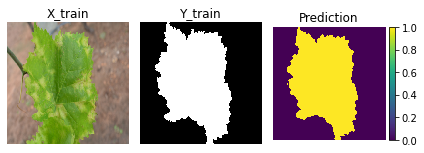

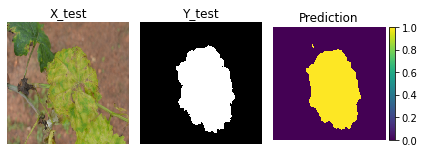

In [ ]:



plotPredictions(x_train,y_train,x_test,y_test,modelZ)



NameError: ignored

NameError: ignored